# Training a Transformer LM

## Problem 1: Implement Cross Entropy
Deliverable: Write a function to compute the cross entropy loss, which takes in predicted logits $\left(o_i\right)$ and targets $\left(x_{i+1}\right)$ and computes the cross entropy $-\log \operatorname{softmax}\left(o_i\right)\left[x_{i+1}\right]$. Your function should handle the following:
- Subtract the largest element for numerical stability.
- Cancel out log and exp whenever possible.
- Handle any additional batch dimensions and return the average across the batch. As with section 3.3, we assume batch-like dimensions always come first, before the vocabulary size dimension.

Implement [adapters.run_cross_entropy], then run `pytest -k test_cross_entropy` to test your implementation.

In [ ]:
import torch.nn as nn 

class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()

    def forward(self, logits, target):
        # compute the loss 
        m = target.shape[-2]
        D = target.shape[-1]
        target = target.view(-1, M+1)
        target = target[:,1:]
        p = nn.functional.softmax(logits, dim=-1)
        p = p.view(-1, M)
        loss = - torch.log(p[range(p.shape[0]), target[:, 0]]).sum()
        return loss/m/D

## Problem 2: Tuning the learning rate 
As we will see, one of the hyperparameters that affects training the most is the learning rate. Let’s see that in practice in our toy example. Run the SGD example above with three other values for the learning rate: 1e1, 1e2, and 1e3, for just 10 training iterations. What happens with the loss for each of these learning rates? Does it decay faster, slower, or does it diverge (i.e., increase over the course of training)?

In [ ]:
from collections.abc import Callable, Iterable
from typing import Optional 
import torch 
import math  

class SGD(torch.optim.Optimizer): 
    def __init__(self, params, lr=1e-3): 
        if lr < 0: 
            raise ValueError(f"Invalid learning rate: {lr}") 
        defaults = {"lr": lr} 
        super().__init__(params, defaults)

    def step(self, closure: Optional[Callable] = None): 
        loss = None if closure is None else closure() 
        for group in self.param_groups:  
            lr = group["lr"] # Get the learning rate. 
            for p in group["params"]: 
                if p.grad is None: 
                    continue 
                state = self.state[p] # Get state associated with p.
                t = state.get("t", 0) # Get iteration number from the state, or initial value. 
                grad = p.grad.data # Get the gradient of loss with respect to p.  
                p.data -= lr / math.sqrt(t + 1) * grad # Update weight tensor in-place. 
                state["t"] = t + 1 # Increment iteration number. 
        return loss

In [8]:
weights = torch.nn.Parameter(5 * torch.randn((10, 10))) 
opt = SGD([weights], lr=1e2)  
print(weights.size())

for t in range(10):  
    opt.zero_grad() # Reset the gradients for all learnable parameters. 
    loss = (weights**2).mean() # Compute a scalar loss value. 
    print(loss.cpu().item())  
    loss.backward() # Run backward pass, which computes gradients. 
    opt.step() # Run optimizer step.

torch.Size([10, 10])
22.707178115844727
22.707178115844727
3.8959357738494873
0.09323850274085999
2.0525248114818022e-16
2.287666418508292e-18
7.703378594576347e-20
4.588954892580547e-21
3.9367021788981355e-22
4.374113812592917e-23


## Problem 3: Implement AdamW
Implement the AdamW optimizer as a subclass of torch.optim.Optimizer. Your class should take the learning rate α in __init__, as well as the β, ε and λ hyperparameters. To help you keep state, the base Optimizer class gives you a dictionary self.state, which maps nn.Parameter objects to a dictionary that stores any information you need for that parameter (for AdamW, this would be the moment estimates). Implement [adapters.get_adamw_cls] and make sure it passes `pytest -k test_adamw`.

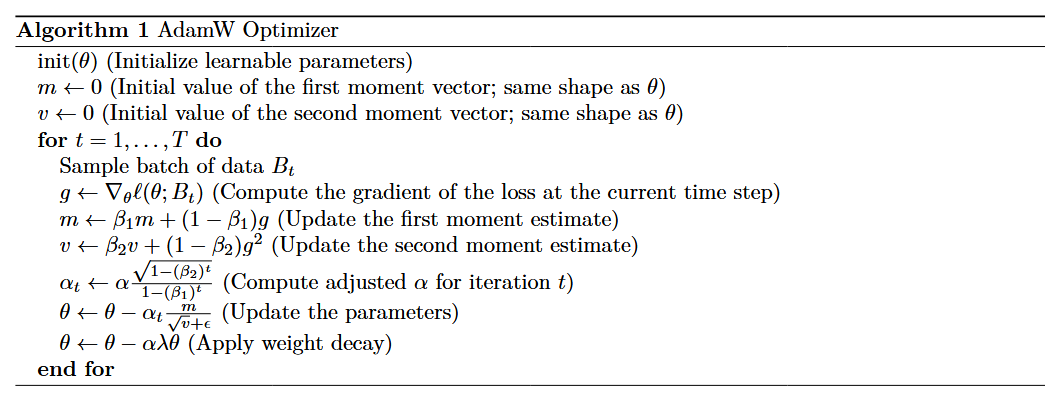

In [ ]:
from collections.abc import Callable, Iterable
from typing import Optional 
import torch 
import math  

class AdamW(torch.optim.Optimizer): 
    def __init__(self, 
        params, lr=1e-3,
        weight_decay=0.01,
        betas=(0.9, 0.999),
        eps=1e-8,): 
        if lr < 0: 
            raise ValueError(f"Invalid learning rate: {lr}") 
        defaults = {"lr": lr, "betas":betas, "eps":eps, "decay":weight_decay} 
        super().__init__(params, defaults)

    def step(self, closure: Optional[Callable] = None): 
        loss = None if closure is None else closure() 
        for group in self.param_groups:  
            lr = group["lr"] # Get the learning rate. 
            beta1, beta2 = group["betas"] # Get the beta values.
            eps = group["eps"] # Get the epsilon value.
            weight_decay = group["decay"] # Get the weight decay value.
            for p in group["params"]: 
                if p.grad is None: 
                    continue 
                state = self.state[p] # Get state associated with p.
                
                t = state.get("t", 0) # Get iteration number from the state, or initial value. 
                m = state.get("m", torch.zeros_like(p)) # Get the first moment estimate.
                v = state.get("v", torch.zeros_like(p)) # Get the second moment estimate.
                grad = p.grad.data # Get the gradient of loss with respect to p.  

                m = beta1 * m + (1 - beta1) * grad # Update biased first moment estimate.
                v = beta2 * v + (1 - beta2) * grad**2 # Update biased second raw moment estimate.
                lr_t = lr * math.sqrt(1 - beta2**(t + 1)) / (1 - beta1**(t + 1)) # Compute the effective learning rate.
                p.data -= lr_t * (m / (torch.sqrt(v) + eps) ) # Update weight tensor in-place.
                p.data -= lr * weight_decay * p.data # Apply weight decay.
                
                state["t"] = t + 1 # Increment iteration number. 
                state["m"] = m # Update first moment estimate.
                state["v"] = v # Update second moment estimate.
        return loss

## Problem 4: Resource accounting for training with AdamW 

Let us compute how much memory and compute running AdamW requires. Assume we are using float32 for every tensor.

- (a) How much peak memory does running AdamW require? Decompose your answer based on the memory usage of the parameters, activations, gradients, and optimizer state. Express your answer in terms of the batch_size and the model hyperparameters (`vocab_size, context_length, num_layers, d_model, num_heads`). Assume `d_ff` = 4 × `d_model`.

- (b) Instantiate your answer for a GPT-2 XL-shaped model to get an expression that only depends on the batch_size. What is the maximum batch size you can use and still fit within 80GB memory?

- (c) How many FLOPs does running one step of AdamW take? 

- (d) Model FLOPs utilization (MFU) is defined as the ratio of observed throughput (tokens per second) relative to the hardware’s theoretical peak FLOP throughput [Chowdhery et al., 2022]. An NVIDIA A100 GPU has a theoretical peak of 19.5 teraFLOP/s for float32 operations. Assuming you are able to get 50% MFU, how long would it take to train a GPT-2 XL for 400K steps and a batch size of 1024 on a single A100? Following Kaplan et al. [2020] and Hoffmann et al. [2022], assume that the backward pass has twice the FLOPs of the forward pass.

- (a) To compute the memory, we just need to check the parameters in the model. 
    - For a transformer block: d_model x d_model x4 + d_modelx2 + d_model x d_model x4 x2 = 12 d_model^2 + 2 d_model 
    - For whole network: num_layer x( 12 d_model^2 + 2 d_model ) + d_model + d_model x vocab_size 
    - For adam + network: a = 3x(num_layer x( 12 d_model^2 + 2 d_model ) + d_model + d_model x vocab_size ) x4
    
    For the activation memory:
    The initial embedding layer, and each of the transformer layers:b= 4x(n_embd x context_length x(n_layer +1 ) + vocab_size)
    Total memory: a + batch_size x b

- (b) a= 18.72 GB, b = 0.321 gb => batch_size <= 191.
- (c) FLOPs of adamW: 17 Flops x N. N is the number of parameters.
- (d) Adam: 25.5 x 10^9 FLOPS. Forward: 133004351504384 FLOPS. Backward: 133004351504384 x2 FLOPs. 



In [10]:
foward_flops = 133004351504384
backward_flops = 133004351504384 * 2
adam_flops = 25.5 *10**9 
total_flops = foward_flops + backward_flops + adam_flops

total_flops * 400 * 100 /(19.5 * 10**12 * 0.5)/3600

454.7447914679795

## Problem 5: Implement cosine learning rate
Write a function that takes $t, \alpha_{\max }, \alpha_{\min }, T_w$ and $T_c$, and returns the learning rate $\alpha_t$ according to the scheduler defined above. Then implement [adapters.get_lr_cosine_schedule] and make sure it passes pytest -k test_get_lr_cosine_schedule.

In [ ]:
def lr_cosine_schedule(t, lr_max, lr_min, t_w, t_c):
    if t < t_w:
        return lr_max * t/t_w
    else:
        if t <= t_c:
            return lr_min + 0.5 * (lr_max - lr_min) * (1 + math.cos(math.pi * (t - t_w) / (t_c - t_w)))
        else:
            return lr_min

## Problem 6: Gradient clipping 
Write a function that implements gradient clipping. Your function should take a list of parameters and a maximum $\ell_2$-norm. It should modify each parameter gradient in place. Use $\epsilon=10^{-6}$ (the PyTorch default). Then, implement the adapter [adapters.run_gradient_clipping] and make sure it passes pytest -k test_gradient_clipping.

In [ ]:
def gradient_clipping(parameters, max_norm, eps=1e-6):
    total_norm2 = 0.0
    for p in parameters:
        if p.grad is not None:
            total_norm2 += torch.sum(p.grad ** 2)
    total_norm = total_norm2 ** 0.5
    if total_norm > max_norm:
        clip_coef = max_norm / (total_norm + eps)
        for param in parameters:
            if param.grad is None:
                continue
            param.grad.mul_(clip_coef)

## Problem 7: Data Loading

Write a function that takes a numpy array x (integer array with token IDs), a batch_size, a context_length and a PyTorch device string (e.g., 'cpu' or 'cuda:0'), and returns a pair of tensors: the sampled input sequences and the corresponding next-token targets. Both tensors should have shape (batch_size, context_length) containing token IDs, and both should be placed on the requested device. To test your implementation against our provided tests, you will first need to implement the test adapter at [adapters.run_get_batch]. Then, run `pytest -k test_get_batch` to test your implementation.

In [ ]:
import torch 
import numpy as np 
from typing import tuple 

def get_batch(
    dataset: np.ndarray,
    batch_size: int,
    context_length: int,
    device: str,
):

    indices = np.random.choice(1, len(dataset) - context_length, batch_size)
    input = torch.stack([torch.tensor(dataset[idx:idx + context_length]) for idx in indices])
    target = torch.stack([torch.tensor(dataset[idx + 1: idx + 1 + context_length]) for idx in indices])
    return input.to(device), target.to(device)

class Dataset:
    def __init__(self, dataset_name, context_length, batch_size, device):
        dataset_path = f'data/{dataset_name}'
        slef.train_data = np.memmap(f'{dataset_path}/train.bin', dtype=np.uint16,mode='r').astype(np.int64) 
        self.valid_data = np.memmap(f'{dataset_path}/valid.bin', dtype=np.uint16,mode='r').astype(np.int64)
        self.context_length = context_length
        self.batch_size = batch_size
        self.device = device

    def get_batch(self, split):
        data = self.train_data if split == 'train' else self.valid_data
        return get_batch(data, self.batch_size, self.context_length, self.device)

## Problem 8: Model checkpointing

In [ ]:
def save_checkpoint(model, optimizer, iteration, out):
    torch.save(
        {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "iteration": iteration,
        },
        out,
    )

def load_checkpoint(src, model, optimizer):
    checkpoint = torch.load(src)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    return checkpoint["iteration"] 

## Problem 9: Text generating

In [ ]:
import torch.nn as nn 
import torch 

def text_generation(model, context, max_length, temperature, topk=None):
    # Assume context is of shape (batch, seq_length); start response as a clone.
    response = context.clone()
    
    # Continue until the sequence length reaches max_length.
    while response.shape[1] < max_length:
        # Compute logits using the current context (i.e. response)
        logits = model(response)
        # Use only the last token's logits and adjust by temperature.
        logits = logits[:, -1, :] / temperature
        probs = nn.functional.softmax(logits, dim=-1)
        
        # If top-k filtering is used, restrict probabilities to the top-k tokens.
        if topk is not None:
            topk_probs, topk_indices = torch.topk(probs, topk, dim=-1)
            # Sample one token index from the top-k probabilities.
            sampled_topk = torch.multinomial(topk_probs, num_samples=1)
            # Map the sampled index back to the vocabulary index.
            new_token = topk_indices.gather(dim=-1, index=sampled_topk)
        else:
            new_token = torch.multinomial(probs, num_samples=1)
        
        # Append the new token to the response.
        response = torch.cat([response, new_token], dim=-1)
        
        # Optionally, if you want to stop generation on an end-of-sequence token (e.g., token id 0)
        if (new_token == 0).all():
            break
    
    return response

